In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
penguins = sns.load_dataset('penguins')

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [4]:
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


Vamos a usar las columnas

"bill_length_mm",
"flipper_length_mm",
"sex",
"body_mass_g"

In [5]:
# Dropeamos las filas que tienen nulls
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

Vamos a calcular ahora el peso medio de cada especie

In [6]:
summary_stats = (penguins.loc[:, ["body_mass_g", "species"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats.round(2)

body_mass_g              
                 mean     std count
species                            
Adelie        3706.16  458.62   146
Chinstrap     3733.09  384.34    68
Gentoo        5092.44  501.48   119

Ahora tenemos el peso medio de cada especie de pingüino, pero no tenemos una medida de la incertidumbre repecto al promedio.

Si bien es cierto que podríamos usar `std/sqrt(count)`, la realidad es que también podemos usar un enfoque bayesiano. Para hacer eso necesitamos definir un prior.

Dado que no tenemos razones específicas para elegir un *prior informativo* vamos a usar un modelo bastante amplio.

Vamos a ir de a poco, concentrándonos primero en una de las 3 especies: Adelie

Una distribución gaussiana es una elección razonable para la likelihood de masa de un pingüino.

*los priors los calibramos a partir de los datos empíricos*

In [7]:
adelie_mask = (penguins['species']== 'Adelie')
adelie_mass_obs= penguins.loc[adelie_mask, 'body_mass_g'].values

## Especificamos los priors y construimos el modelo

In [8]:
with pm.Model() as model_adelie:

    # Definir el modelo
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    # Calcular la posterior
    idata = pm.sample(chains=4)

    #Agregar la prior predictive
    prior_pred = pm.sample_prior_predictive(samples=5000)
    idata.extend(prior_pred)

Output()

Output()

Output()

Output()

In [26]:
model_adelie

In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

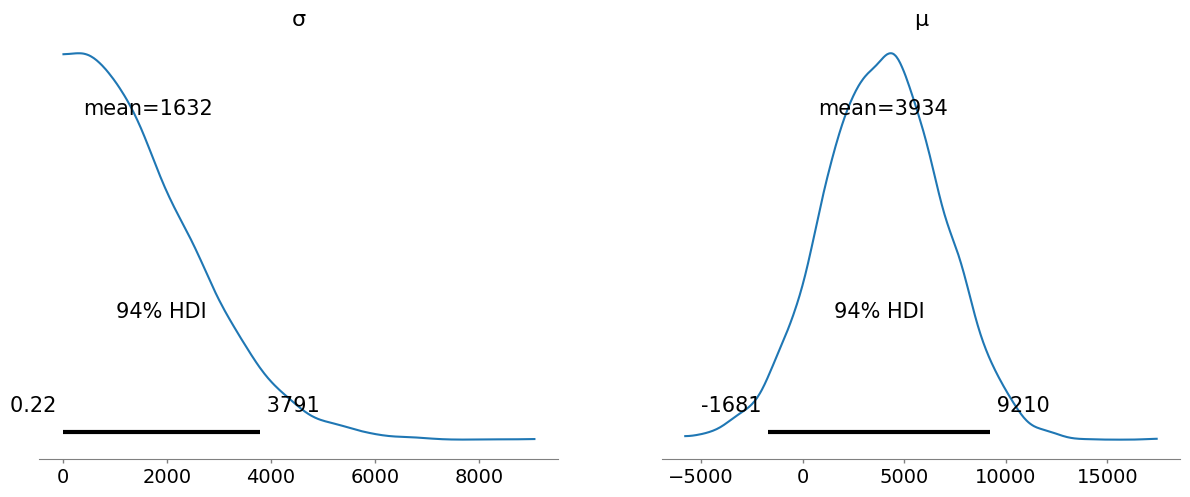

In [10]:
# Revisamos nuestros priors

# usamos plot_posterior, pero pasamos la data del prior
az.plot_posterior(idata.prior,  var_names=["σ", "μ"]);

# Vemos que no estamos sobre-restringiendo al modelo

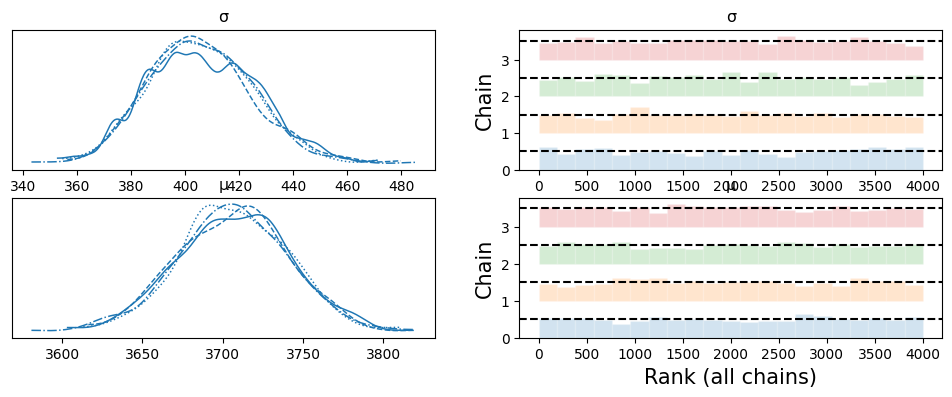

In [11]:
# Revisamos el ajuste:

az.plot_trace(idata, var_names=["σ", "μ"], kind="rank_bars");

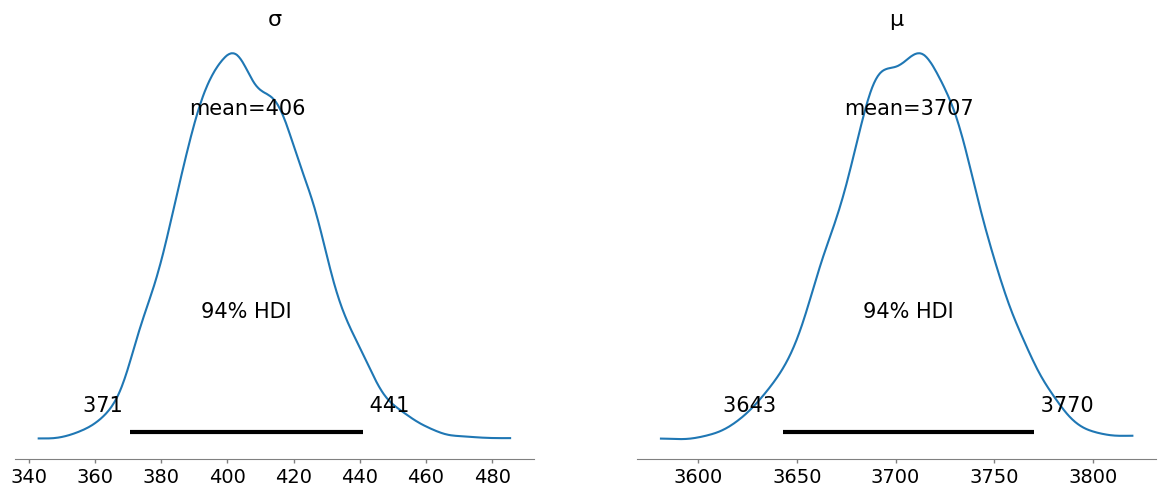

In [12]:
# Ploteamos la posterior

az.plot_posterior(idata,  var_names=["σ", "μ"]);

# Estimando un modelo para las 3 especies

Ahora que entendemos la mecánica, vamos a estimar un modelo para la media de cada especie.  

Por supuesto, podríamos estar un modelo para cada especie, pero podemos estimar un modelo para los 3 grupos separados.

In [13]:
all_species = pd.Categorical(penguins['species'])

In [14]:
with pm.Model() as model_all_species:
  # Agregamos un parámetros 'shape' para dar cuenta de que son 3 distribuciones
  σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
  μ = pm.Normal("μ", 4000, 3000, shape=3)
  mass = pm.Normal("mass",
                   mu=μ[all_species.codes],
                   sigma=σ[all_species.codes],
                   observed=penguins["body_mass_g"])

  idata = pm.sample(chains=4)

Output()

Output()

Output()

Output()

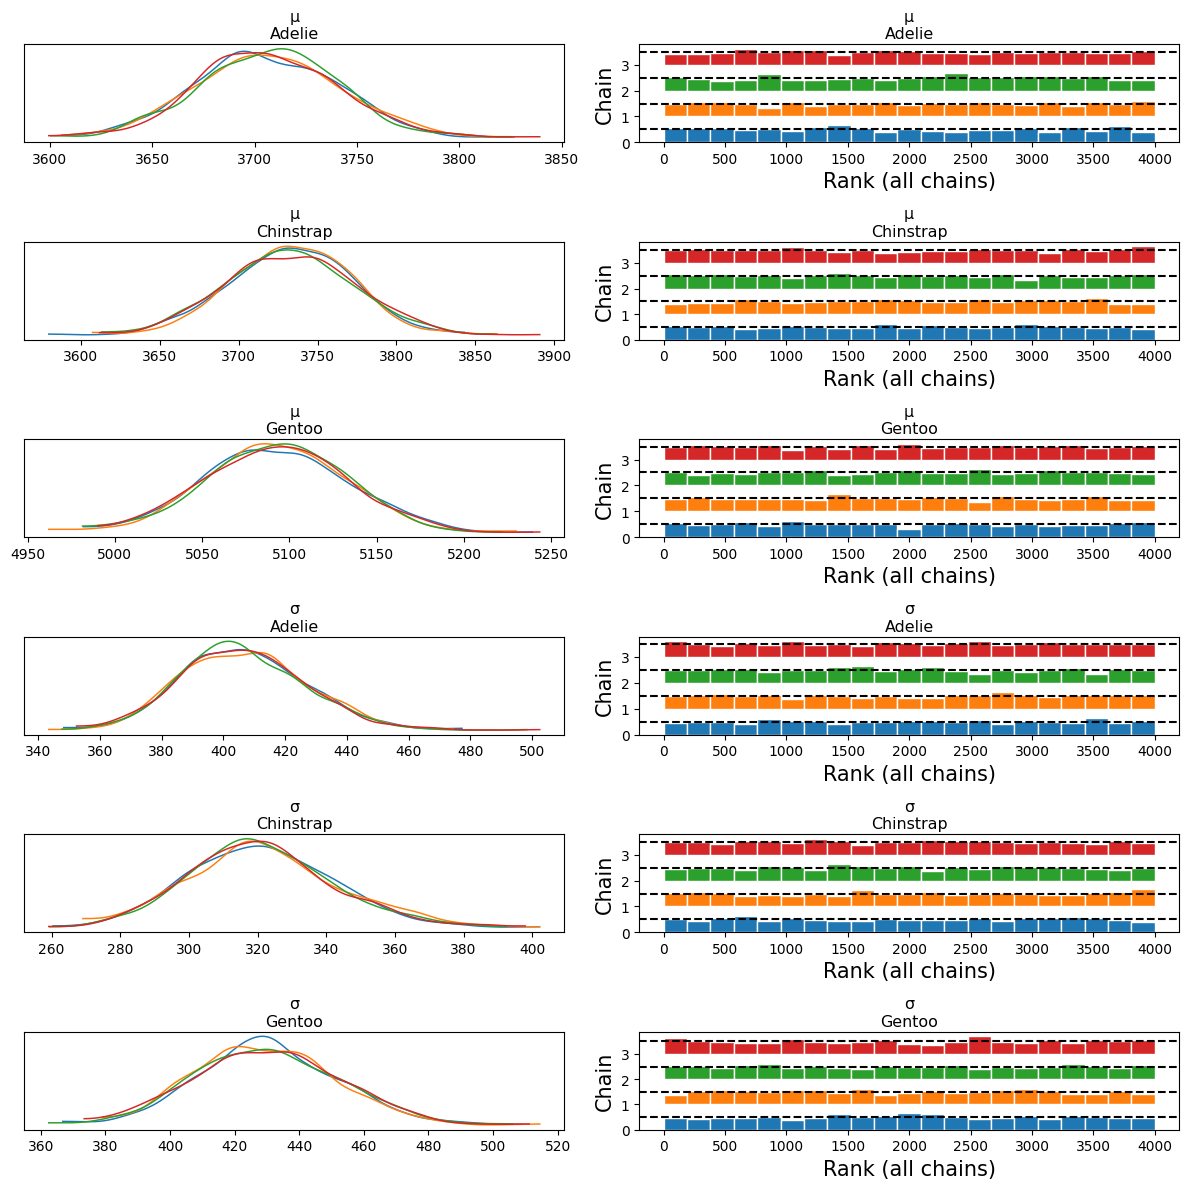

In [15]:
# Agregamos etiquetas
idata = idata.assign_coords(
    {"μ_dim_0": all_species.categories, "σ_dim_0": all_species.categories})

az.plot_trace(idata,
              compact = False,
              kind="rank_bars"
              )
plt.tight_layout()
plt.show()


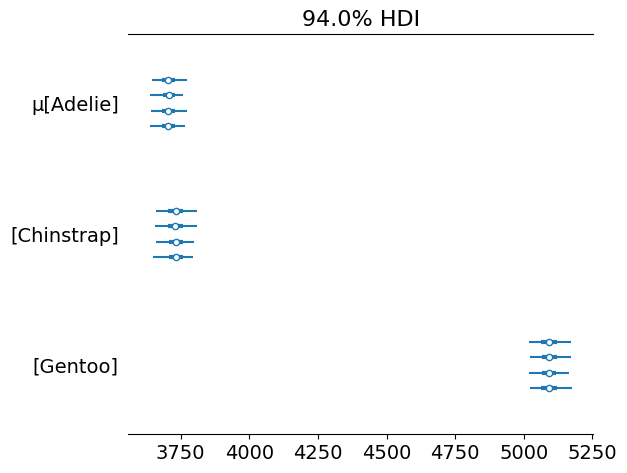

In [16]:
# Comparamos los HDIs para la media de cada especie
az.plot_forest(idata, var_names=["μ"]);

# Regresión Lineal Bayesiana

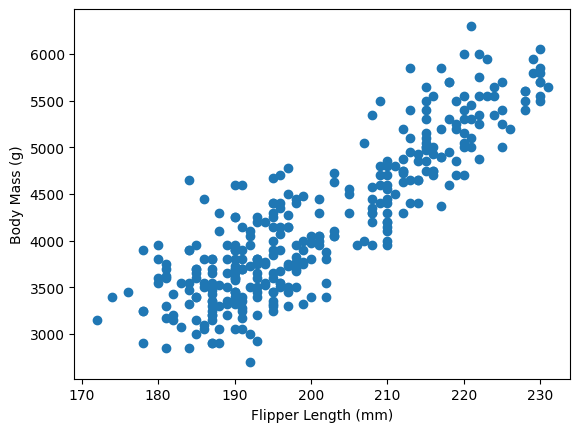

In [17]:
# Scatter (EDA)
fig, ax = plt.subplots()

ax.scatter(penguins["flipper_length_mm"], penguins["body_mass_g"])
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")

plt.show()

In [18]:
with pm.Model() as bayesian_regression:
  # pm.Data() nor permite luego cambiar los valores
  flipper_lenght = pm.Data("flipper_lenght", penguins["flipper_length_mm"])
  body_mass = pm.Data("body_mass", penguins["body_mass_g"])

  # Priors
  alpha = pm.Normal("alpha", mu=0, sigma=4000)
  beta = pm.Normal("beta", mu=0, sigma=4000)
  sigma = pm.HalfStudentT("sigma", 100, 2000)

  # Likelihood
  mu = pm.Deterministic('mu', alpha + beta * flipper_lenght)
  mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=body_mass)

  # Samplear de la posterior
  idata_linreg = pm.sample(chains=4)

Output()

Output()

Output()

Output()

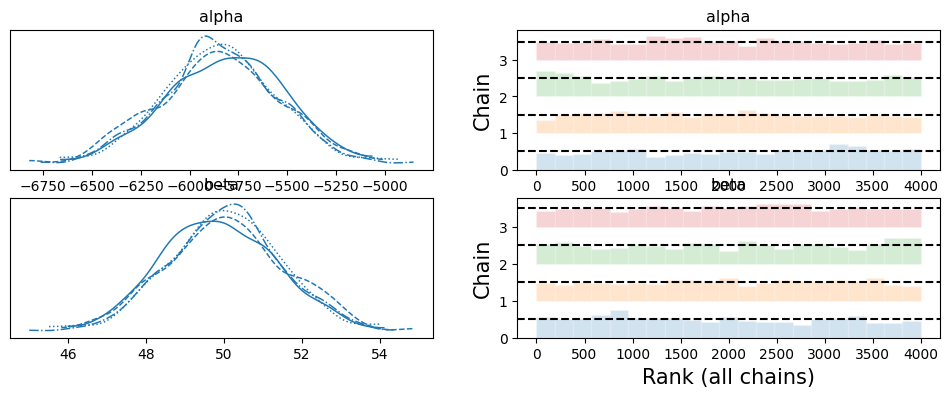

In [19]:
az.plot_trace(idata_linreg, kind="rank_bars",var_names = ['alpha', 'beta']);

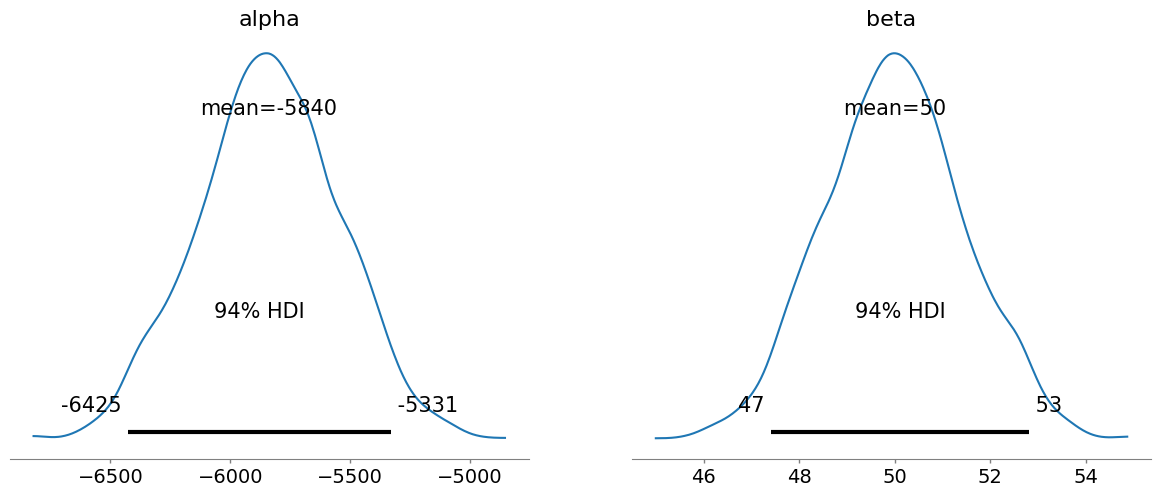

In [20]:
az.plot_posterior(idata_linreg, var_names = ['alpha', 'beta']);

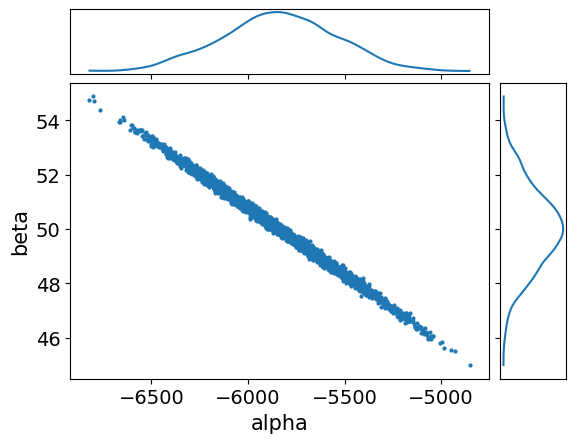

In [21]:
az.plot_pair(idata_linreg, marginals=True, var_names = ['alpha', 'beta']);

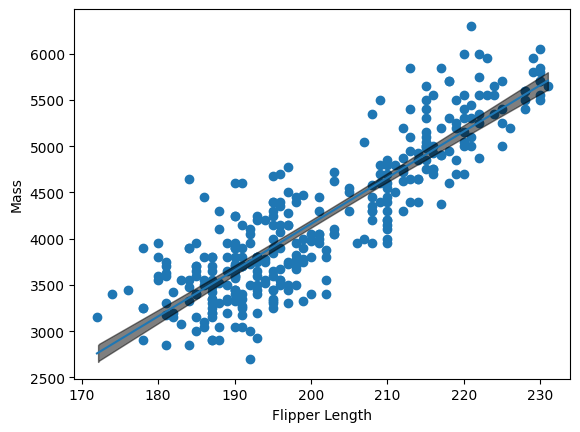

In [22]:
flipper_length_mm = penguins["flipper_length_mm"]
body_mass_g = penguins["body_mass_g"]

fig, ax = plt.subplots()
alpha_m = idata_linreg.posterior.mean().to_dict()["data_vars"]["alpha"]["data"]
beta_m = idata_linreg.posterior.mean().to_dict()["data_vars"]["beta"]["data"]

flipper_lenght_axis = np.linspace(flipper_length_mm.min(), flipper_length_mm.max(), 1000)

y_pred_mean = alpha_m + beta_m * flipper_lenght_axis

# Scatter
ax.scatter(flipper_length_mm, body_mass_g)


# Recta de Regresión en posterior mean
ax.plot(flipper_lenght_axis, y_pred_mean)

# Agregar los HDI
az.plot_hdi(flipper_length_mm, idata_linreg.posterior['mu'], hdi_prob=0.95, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');

In [23]:
# Posterior predictive para un pinguino con longitud de aleta igual al promedio

with bayesian_regression:
    pm.set_data({"flipper_lenght": [penguins["flipper_length_mm"].mean()]})
    mass_for_average_flipper_lenght = pm.sample_posterior_predictive(idata_linreg)

Output()

In [24]:
posterior_ = mass_for_average_flipper_lenght.posterior_predictive['mass'].values.flatten()

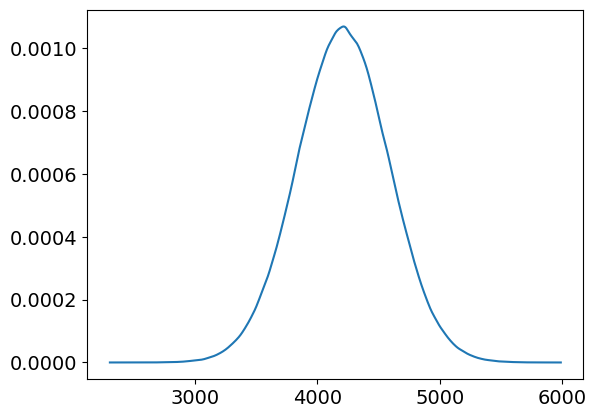

In [25]:
az.plot_dist(posterior_);